# Generating new MNIST digits with GAN
<hr>
Source: https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py
<hr>

In [2]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

In [3]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

## Step 1: Load the dataset

In [4]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

In [5]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

## Step 2: Build the generator model

In [8]:
generator = Sequential(name = 'generator')
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 784)               80

## Step 3: Build the discriminator model

In [9]:
discriminator = Sequential(name = 'discriminator')
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)             

## Step 4: Build GAN model = generator + discriminator

In [10]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Sequential)       (None, 784)               1486352   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


## Step 5: Prepare functions to produce and plot the results

In [25]:
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount) 

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15) 
        for i in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            plotGeneratedImages(e)
            saveModels(e)
    
    # Plot losses from every epoch
    plotLoss(e)

## Step 6: Fit GAN model & plot reults

  0%|          | 2/468 [00:00<00:38, 12.02it/s]

Epochs: 100
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:35, 13.08it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:36, 12.80it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:35, 13.09it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:36, 12.80it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:35, 13.14it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:35, 13.02it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:36, 12.64it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:37, 12.37it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:36, 12.67it/s]

--------------- Epoch 10 ---------------


  0%|          | 2/468 [00:00<00:36, 12.63it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:36, 12.71it/s]

--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:37, 12.47it/s]

--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:36, 12.76it/s]

--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:36, 12.89it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:36, 12.89it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:37, 12.55it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:36, 12.80it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:37, 12.49it/s]

--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:36, 12.84it/s]

--------------- Epoch 20 ---------------


  0%|          | 2/468 [00:00<00:38, 11.98it/s]

--------------- Epoch 21 ---------------


  0%|          | 2/468 [00:00<00:36, 12.71it/s]

--------------- Epoch 22 ---------------


  0%|          | 2/468 [00:00<00:36, 12.83it/s]

--------------- Epoch 23 ---------------


  0%|          | 2/468 [00:00<00:36, 12.68it/s]

--------------- Epoch 24 ---------------


  0%|          | 2/468 [00:00<00:37, 12.51it/s]

--------------- Epoch 25 ---------------


  0%|          | 2/468 [00:00<00:36, 12.69it/s]

--------------- Epoch 26 ---------------


  0%|          | 2/468 [00:00<00:36, 12.78it/s]

--------------- Epoch 27 ---------------


  0%|          | 2/468 [00:00<00:36, 12.68it/s]

--------------- Epoch 28 ---------------


  0%|          | 2/468 [00:00<00:37, 12.45it/s]

--------------- Epoch 29 ---------------


  0%|          | 2/468 [00:00<00:36, 12.62it/s]

--------------- Epoch 30 ---------------


  0%|          | 2/468 [00:00<00:36, 12.69it/s]

--------------- Epoch 31 ---------------


  0%|          | 2/468 [00:00<00:37, 12.38it/s]

--------------- Epoch 32 ---------------


  0%|          | 2/468 [00:00<00:36, 12.82it/s]

--------------- Epoch 33 ---------------


  0%|          | 2/468 [00:00<00:38, 12.23it/s]

--------------- Epoch 34 ---------------


  0%|          | 2/468 [00:00<00:37, 12.43it/s]

--------------- Epoch 35 ---------------


  0%|          | 2/468 [00:00<00:36, 12.93it/s]

--------------- Epoch 36 ---------------


  0%|          | 2/468 [00:00<00:37, 12.59it/s]

--------------- Epoch 37 ---------------


  0%|          | 2/468 [00:00<00:36, 12.65it/s]

--------------- Epoch 38 ---------------


  0%|          | 2/468 [00:00<00:36, 12.68it/s]

--------------- Epoch 39 ---------------


  0%|          | 2/468 [00:00<00:37, 12.47it/s]

--------------- Epoch 40 ---------------


  0%|          | 2/468 [00:00<00:36, 12.63it/s]

--------------- Epoch 41 ---------------


  0%|          | 2/468 [00:00<00:37, 12.43it/s]

--------------- Epoch 42 ---------------


  0%|          | 2/468 [00:00<00:37, 12.46it/s]

--------------- Epoch 43 ---------------


  0%|          | 2/468 [00:00<00:38, 12.19it/s]

--------------- Epoch 44 ---------------


  0%|          | 2/468 [00:00<00:36, 12.92it/s]

--------------- Epoch 45 ---------------


  0%|          | 2/468 [00:00<00:36, 12.64it/s]

--------------- Epoch 46 ---------------


  0%|          | 2/468 [00:00<00:36, 12.71it/s]

--------------- Epoch 47 ---------------


  0%|          | 2/468 [00:00<00:36, 12.76it/s]

--------------- Epoch 48 ---------------


  0%|          | 2/468 [00:00<00:38, 12.19it/s]

--------------- Epoch 49 ---------------


  0%|          | 2/468 [00:00<00:36, 12.82it/s]

--------------- Epoch 50 ---------------


  0%|          | 2/468 [00:00<00:37, 12.32it/s]

--------------- Epoch 51 ---------------


  0%|          | 2/468 [00:00<00:38, 12.19it/s]

--------------- Epoch 52 ---------------


  0%|          | 2/468 [00:00<00:36, 12.69it/s]

--------------- Epoch 53 ---------------


  0%|          | 2/468 [00:00<00:36, 12.69it/s]

--------------- Epoch 54 ---------------


  0%|          | 2/468 [00:00<00:36, 12.73it/s]

--------------- Epoch 55 ---------------


  0%|          | 2/468 [00:00<00:36, 12.60it/s]

--------------- Epoch 56 ---------------


  0%|          | 2/468 [00:00<00:36, 12.86it/s]

--------------- Epoch 57 ---------------


  0%|          | 2/468 [00:00<00:37, 12.56it/s]

--------------- Epoch 58 ---------------


  0%|          | 2/468 [00:00<00:38, 12.23it/s]

--------------- Epoch 59 ---------------


  0%|          | 2/468 [00:00<00:38, 12.12it/s]

--------------- Epoch 60 ---------------


  0%|          | 2/468 [00:00<00:39, 11.86it/s]

--------------- Epoch 61 ---------------


  0%|          | 2/468 [00:00<00:39, 11.92it/s]

--------------- Epoch 62 ---------------


  0%|          | 2/468 [00:00<00:37, 12.29it/s]

--------------- Epoch 63 ---------------


  0%|          | 2/468 [00:00<00:39, 11.71it/s]

--------------- Epoch 64 ---------------


  0%|          | 2/468 [00:00<00:39, 11.66it/s]

--------------- Epoch 65 ---------------


  0%|          | 2/468 [00:00<00:37, 12.29it/s]

--------------- Epoch 66 ---------------


  0%|          | 2/468 [00:00<00:39, 11.88it/s]

--------------- Epoch 67 ---------------


  0%|          | 2/468 [00:00<00:36, 12.66it/s]

--------------- Epoch 68 ---------------


  0%|          | 2/468 [00:00<00:37, 12.52it/s]

--------------- Epoch 69 ---------------


  0%|          | 2/468 [00:00<00:38, 12.05it/s]

--------------- Epoch 70 ---------------


  0%|          | 2/468 [00:00<00:37, 12.36it/s]

--------------- Epoch 71 ---------------


  0%|          | 2/468 [00:00<00:38, 12.10it/s]

--------------- Epoch 72 ---------------


  0%|          | 2/468 [00:00<00:39, 11.72it/s]

--------------- Epoch 73 ---------------


  0%|          | 2/468 [00:00<00:37, 12.29it/s]

--------------- Epoch 74 ---------------


  0%|          | 2/468 [00:00<00:37, 12.38it/s]

--------------- Epoch 75 ---------------


  0%|          | 2/468 [00:00<00:39, 11.68it/s]

--------------- Epoch 76 ---------------


  0%|          | 2/468 [00:00<00:38, 12.03it/s]

--------------- Epoch 77 ---------------


  0%|          | 2/468 [00:00<00:38, 12.00it/s]

--------------- Epoch 78 ---------------


  0%|          | 2/468 [00:00<00:40, 11.64it/s]

--------------- Epoch 79 ---------------


  0%|          | 2/468 [00:00<00:39, 11.78it/s]

--------------- Epoch 80 ---------------


  0%|          | 2/468 [00:00<00:38, 12.15it/s]

--------------- Epoch 81 ---------------


  0%|          | 2/468 [00:00<00:39, 11.85it/s]

--------------- Epoch 82 ---------------


  0%|          | 2/468 [00:00<00:40, 11.39it/s]

--------------- Epoch 83 ---------------


  0%|          | 2/468 [00:00<00:39, 11.68it/s]

--------------- Epoch 84 ---------------


  0%|          | 2/468 [00:00<00:39, 11.65it/s]

--------------- Epoch 85 ---------------


  0%|          | 2/468 [00:00<00:36, 12.62it/s]

--------------- Epoch 86 ---------------


  0%|          | 2/468 [00:00<00:39, 11.71it/s]

--------------- Epoch 87 ---------------


  0%|          | 2/468 [00:00<00:39, 11.91it/s]

--------------- Epoch 88 ---------------


  0%|          | 2/468 [00:00<00:40, 11.61it/s]

--------------- Epoch 89 ---------------


  0%|          | 2/468 [00:00<00:38, 12.25it/s]

--------------- Epoch 90 ---------------


  0%|          | 2/468 [00:00<00:39, 11.73it/s]

--------------- Epoch 91 ---------------


  0%|          | 2/468 [00:00<00:40, 11.57it/s]

--------------- Epoch 92 ---------------


  0%|          | 2/468 [00:00<00:36, 12.70it/s]

--------------- Epoch 93 ---------------


  0%|          | 2/468 [00:00<00:40, 11.51it/s]

--------------- Epoch 94 ---------------


  0%|          | 2/468 [00:00<00:39, 11.65it/s]

--------------- Epoch 95 ---------------


  0%|          | 2/468 [00:00<00:39, 11.65it/s]

--------------- Epoch 96 ---------------


  0%|          | 2/468 [00:00<00:37, 12.47it/s]

--------------- Epoch 97 ---------------


  0%|          | 2/468 [00:00<00:41, 11.25it/s]

--------------- Epoch 98 ---------------


  0%|          | 2/468 [00:00<00:40, 11.48it/s]

--------------- Epoch 99 ---------------


  0%|          | 2/468 [00:00<00:38, 12.24it/s]

--------------- Epoch 100 ---------------


100%|██████████| 468/468 [00:39<00:00, 11.99it/s]


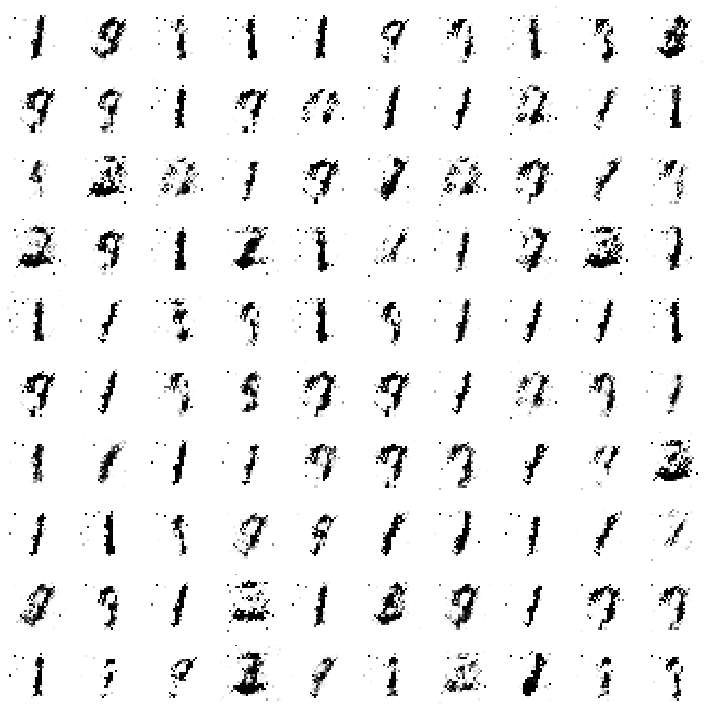

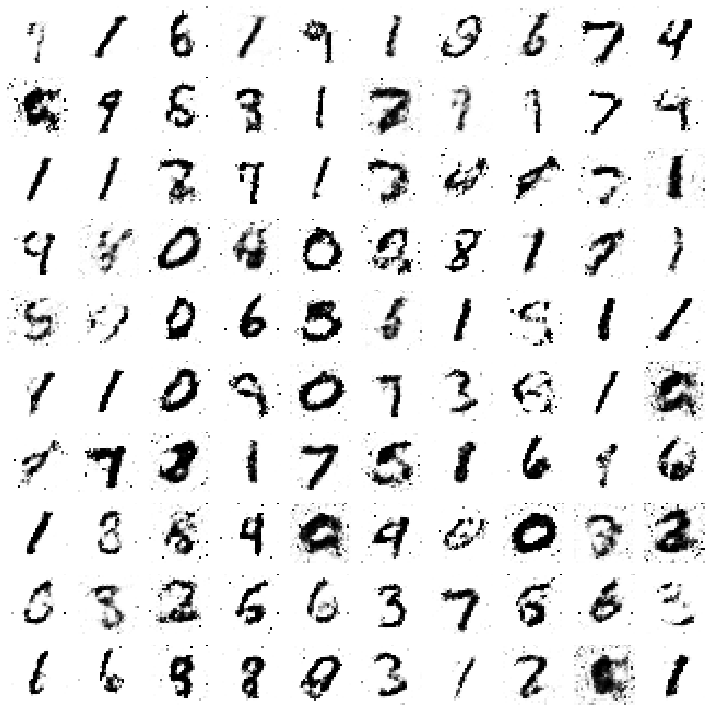

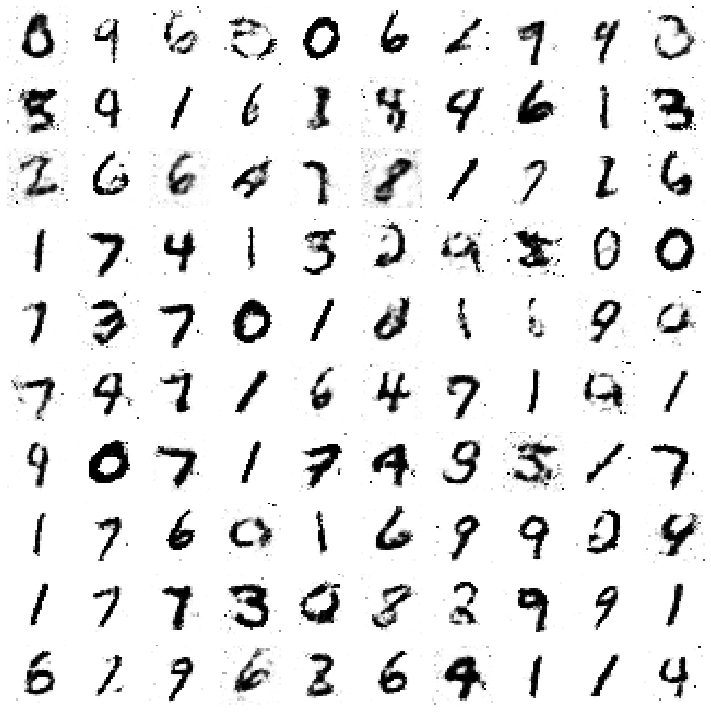

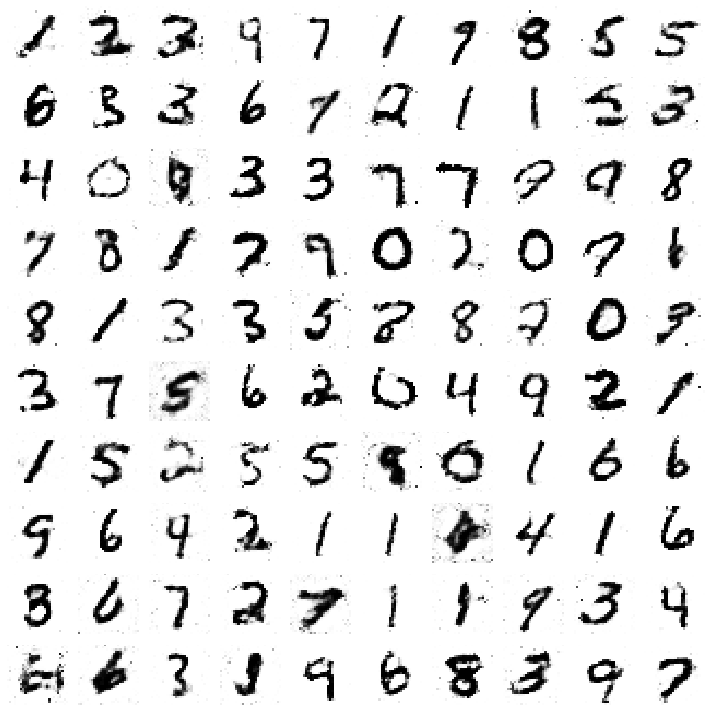

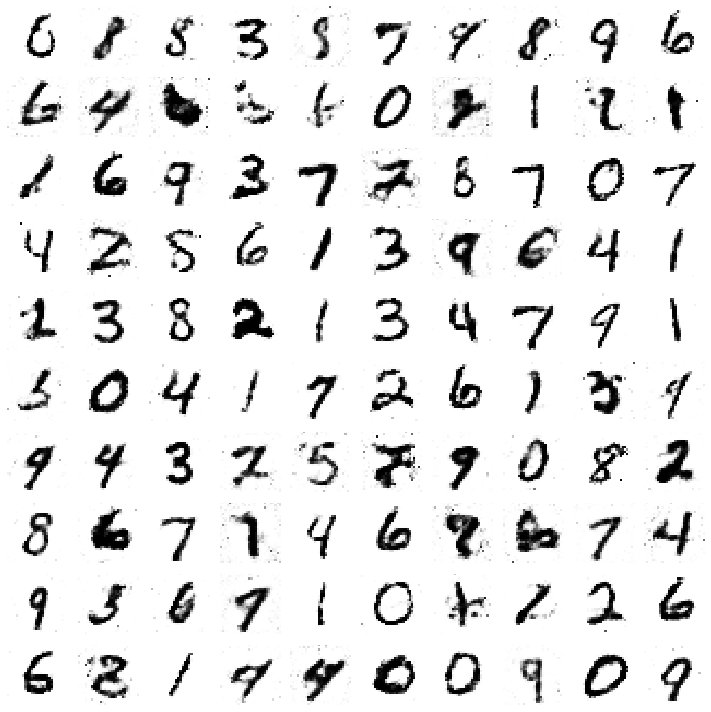

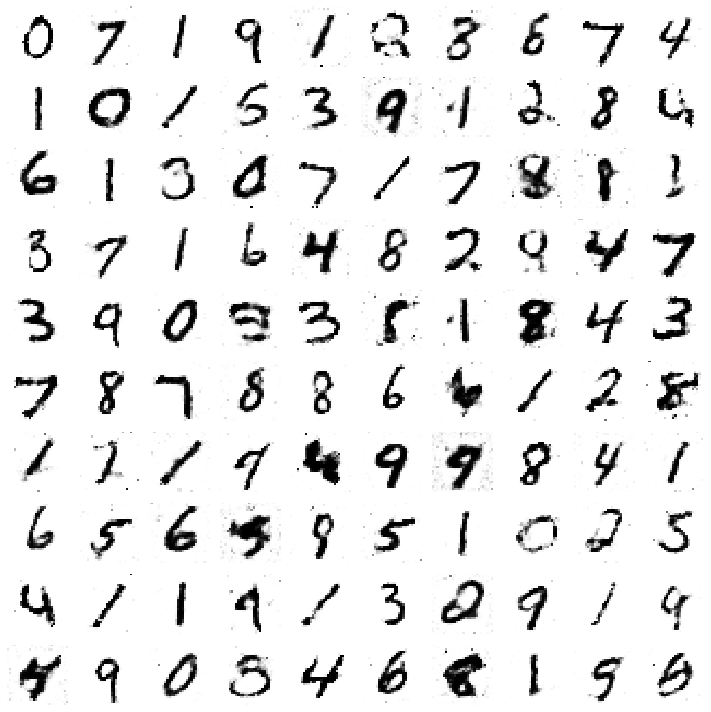

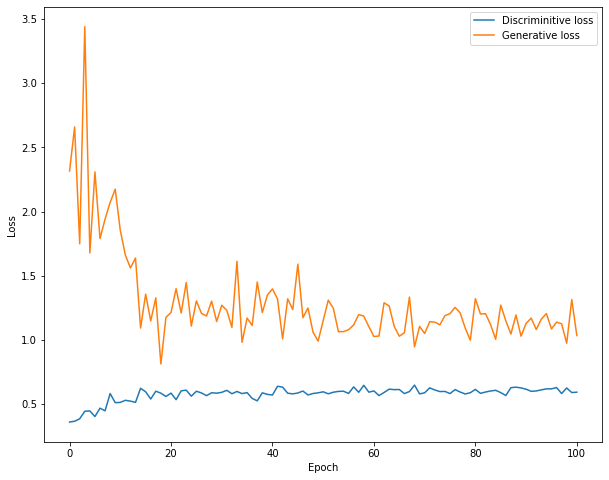

In [27]:
 train(100, 128)